# Lisez-moi

Ce notebook charge les données des contours disponibles sur Atlasante (https://catalogue.atlasante.fr/geosource/panierDownloadFrontalParametrage/d51b5c43-812d-420f-a641-83e18ddb8628) avec les paramètres suivants :
- **Format des données** : ESRI (shp)
- **Projection** : Lambert 93 EPSG:2154

**Réalisations effectuées :**
- Contours de toutes les UDI en France Métropolitaine
- Contours des UDI à Paris, étant identifiée comme une commune avec plusieurs UDI (comparaison <u>visuelle</u> avec la carte officielle (https://qualite.eaudeparis.fr/) --> semble coller)
- Saisie d'une adresse et détermination des coordonnées
- Croisement des coordonnées de l'adresse avec la liste des UDI et détermination de l'UDI desservant l'adresse
- Carto de l'adresse + UDI de l'adresse

**Il est nécessaire d'avoir installé les librairies suivantes :**
- geopandas
- matplotlib
- folium
- shapely
- pyproj
- geopy
- IPython

# Packages

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
from pyproj import Transformer
from shapely.geometry import Point
from IPython.display import display

# Liens répertoires et fichiers

In [2]:
REPERTOIRE_DATA_ATLASANTE = (
    "C:\\Users\\simon\\Documents\\Data\\Pollution_eau\\ATLASANTE\\"
)

NOM_FICHIER_CONTOURS_UDI = "dgs_metropole_udi_infofactures_j.shp"

In [3]:
# Lecture du fichier des contours (shapfeile)
gdf_udi = gpd.read_file(REPERTOIRE_DATA_ATLASANTE + NOM_FICHIER_CONTOURS_UDI)

# Aperçu
gdf_udi.head()

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\simon\Documents\Data\Pollution_eau\ATLASANTE\dgs_metropole_udi_infofactures_j.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


,gid,code_udi,code_ins,ins_nom,ins_etat,udi_pop,uge_code,uge_nom,uge_exp_cn,uge_exp_no,uge_mo_cn,uge_mo_nom,geometry
0,1,063001807,063001807,FERRY,ACT,0,0630025,ASA DE FERRY BESSE BESSETTES,06300495,ASA DE FERRY BESSE BESSETTES,06300495,ASA DE FERRY BESSE BESSETTES,"POLYGON ((769233 6480196, 767772.022 6480179.1..."
1,2,026000696,026000696,BARNAVE VILLAGE,ACT,0,0260179,COMMUNE BARNAVE,02600217,MAIRIE DE BARNAVE,02600217,MAIRIE DE BARNAVE,"POLYGON ((889551.831 6398412.765, 889484.269 6..."
2,3,074002291,074002291,LA COTE D'EN HAUT,ACT,None,0740194,VAILLY,07400280,MAIRIE DE VAILLY,07400280,MAIRIE DE VAILLY,"POLYGON ((970942.478 6584940.754, 970951.895 6..."
3,4,087001239,087001239,LAURIERE,ACT,0,0870070,LAURIERE,08700192,COMMUNE DE LAURIERE,08700192,COMMUNE DE LAURIERE,"POLYGON ((584802.827 6552144.746, 584808.22 65..."
4,5,073001267,073001267,ST BON CHEF LIEU,ACT,341,0730189,COURCHEVEL,07300011,SUEZ,07300215,MAIRIE DE COURCHEVEL,"POLYGON ((984389.654 6488993.567, 984419.538 6..."


# Cartographie des UDI

## En France Métro

<Axes: >

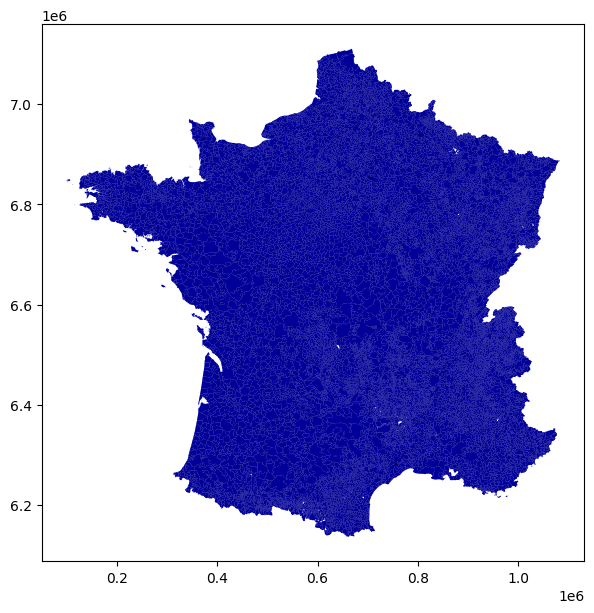

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))
gdf_udi.plot(ax=ax, alpha=0.4, color="black", zorder=10)
gdf_udi.plot(ax=ax, markersize=20, color="blue", marker="o", zorder=2)

## À Paris
Il y a 4 UDI desservant Paris.
Carte officielle Eau de Paris disponible ici : https://qualite.eaudeparis.fr/

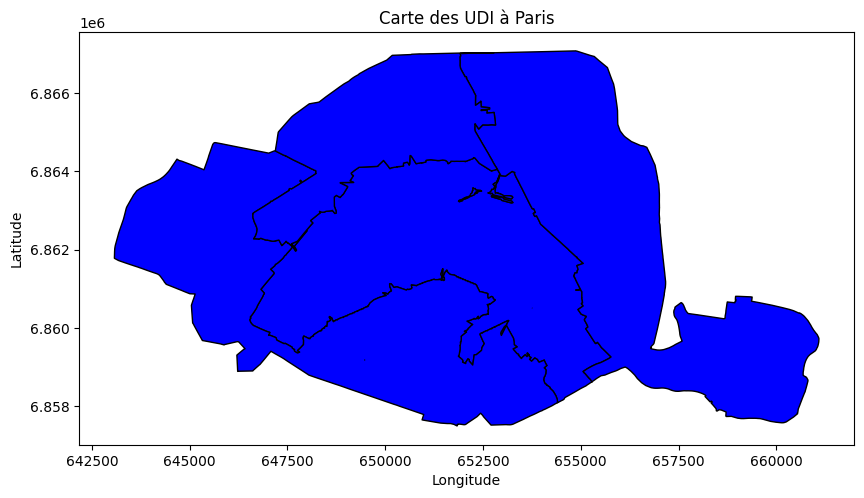

In [5]:
gdf_udi_paris = gdf_udi[gdf_udi["uge_exp_no"] == "EAU DE PARIS"]

fig, ax = plt.subplots(figsize=(10, 10))
gdf_udi_paris.plot(ax=ax, color="blue", edgecolor="black")
ax.set_title("Carte des UDI à Paris")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Saisie d'une adresse et localisation

## Test avec les UDI de Paris

In [6]:
# Saisie de l'adresse
geolocator = Nominatim(user_agent="http")

### Saisir une adresse ici

In [7]:
adresse = "3 boulevard St Germain, Paris"

In [8]:
location = geolocator.geocode(adresse, addressdetails=True)
LDN_COORDINATES = (location.latitude, location.longitude)

# Transformer la projection du point (EPSG:4326 à EPSG:2154 pour coller avec les contours des UDI)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154", always_xy=True)
adresse_long, adresse_lat = transformer.transform(location.longitude, location.latitude)
point_adresse = Point(adresse_long, adresse_lat)

In [9]:
# Création de la carte avec folium
carte = folium.Map(location=LDN_COORDINATES, zoom_start=12)

folium.Choropleth(
    geo_data=gdf_udi_paris,
    key_on="feature.properties.name",
    columns=["name", "pop_est"],
    fill_color="YlOrBr",
).add_to(carte)

folium.LayerControl().add_to(carte)

folium.Marker([location.latitude, location.longitude], popup=adresse).add_to(carte)

display(carte)

### Détection de l'UDI desservant l'adresse

In [10]:
for idx, row in gdf_udi_paris.iterrows():
    if row["geometry"].contains(point_adresse):
        print(
            f"L'adresse {adresse} est dans l'UDI suivante : {row['ins_nom']} ({row['code_ins']})"
        )
        break
else:
    print("Aucune UDI n'a pu être trouvée pour l'adresse saisie")

L'adresse 3 boulevard St Germain, Paris est dans l'UDI suivante : CENTRE (075000221)


In [11]:
# Création de la carte avec l'UDI de l'adresse
carte = folium.Map(location=LDN_COORDINATES, zoom_start=12)

folium.Choropleth(
    geo_data=gdf_udi_paris.loc[[idx]],
    key_on="feature.properties.name",
    columns=["name", "pop_est"],
    fill_color="YlOrBr",
).add_to(carte)

folium.LayerControl().add_to(carte)

folium.Marker([location.latitude, location.longitude], popup=adresse).add_to(carte)

display(carte)